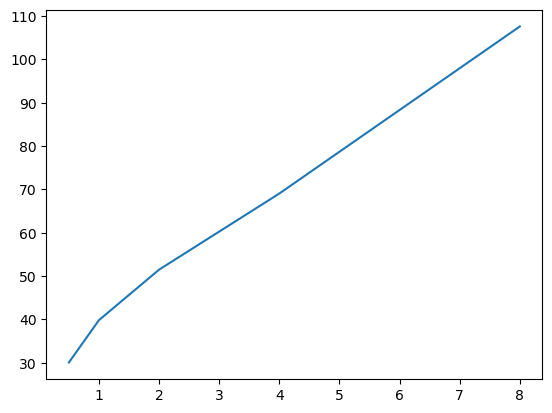

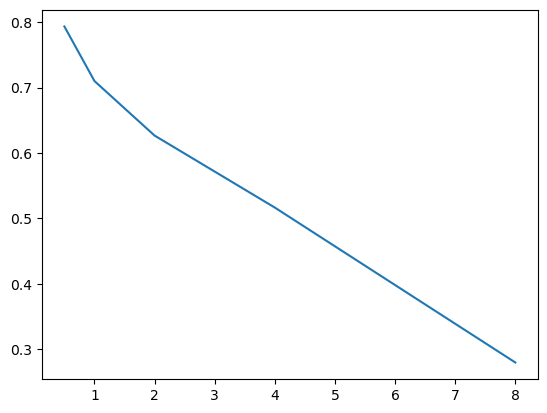

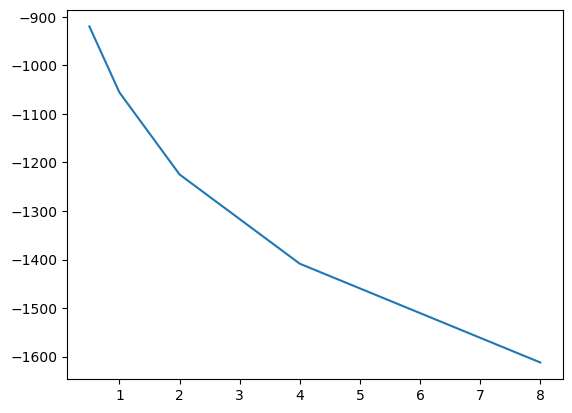

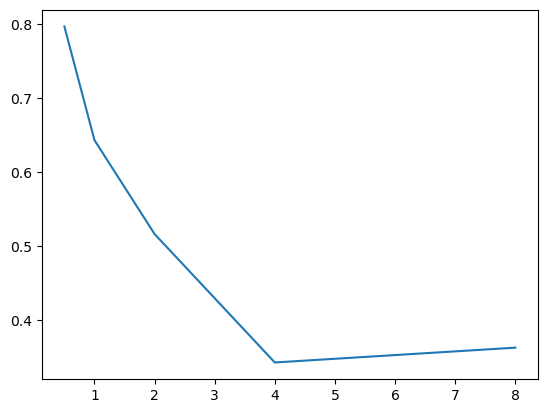

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def kmeans(dataset, k):
    shape = dataset.shape
    mu_arr = np.zeros((k, shape[1]))
    label_arr = np.zeros(shape[0])
    
    def kmeanspp_init(dataset, k):
        mu_arr = np.zeros((k, shape[1]))
        
        x = np.random.uniform()
        ind = int(np.rint(x * len(dataset)))
        mu_arr[0] = dataset[ind]
        dataset_ = np.delete(dataset, ind, axis=0)
        # print(dataset_.shape)
        for i in range(1, k):
            diff = dataset_ - mu_arr[i-1]
            distance = np.linalg.norm(diff, axis = 1)
            cum_sum = np.cumsum(distance)
            x = np.random.uniform()*cum_sum[-1]
            # print(x)
            a = cum_sum > x
            ind = np.argwhere(a)[0]
            mu_arr[i] = dataset_[ind]
            dataset_ = np.delete(dataset_, ind, axis = 0)           
        return mu_arr
    
    def update_centroid(label_arr, dataset, k):
        mu_arr = np.zeros((k, dataset.shape[1]))
        objective = np.zeros(k)
        for i in range(k):
            d = dataset[label_arr == i]
            mu_arr[i] = np.average(d, axis = 0)
            objective[i] = np.linalg.norm(d - mu_arr[i])
        objective = np.sum(objective)
        return mu_arr, objective
        
    mu_arr = kmeanspp_init(dataset, k)
    # print(mu_arr)
    converged = False
    while (converged != True):
        for i in range(len(dataset)):
            data = dataset[i]
            dist = np.linalg.norm(data - mu_arr, axis = 1)
            ind = np.argmin(dist)
            label_arr[i] = ind
        
        mu_arr_new, objective = update_centroid(label_arr, dataset, k)
        # print(mu_arr_new)
        c = np.isclose(mu_arr_new, mu_arr)
        # print(c)
        if np.all(c) == True:
            converged = True
        mu_arr = mu_arr_new
    # print(mu_arr)
    
    return mu_arr, label_arr, objective

def gen_dataset(sigma):
    mean = np.array([-1, -1])
    std = np.array([[2, 0.5], [0.5,1]])
    pa = np.random.multivariate_normal(mean, sigma*std, 100)
    mean = np.array([1, -1])
    std = np.array([[1, -0.5], [-0.5, 2]])
    pb = np.random.multivariate_normal(mean, sigma*std, 100)
    mean = np.array([0, 1])
    std = np.array([[1, 0], [0,2]])
    pc = np.random.multivariate_normal(mean, sigma*std, 100)
    dataset = np.concatenate([pa,pb,pc], axis=0)
    # print(dataset.shape)
    return dataset

def gmm(dataset, k, n_iter):
    
    def init(dataset, k):
        mu_arr = np.zeros((k, dataset.shape[1]))
        x = np.random.uniform()
        ind = int(np.rint(x * len(dataset)))
        mu_arr[0] = dataset[ind]
        dataset_ = np.delete(dataset, ind, axis=0)
        # print(dataset_.shape)
        for i in range(1, k):
            diff = dataset_ - mu_arr[i-1]
            distance = np.linalg.norm(diff, axis = 1)
            cum_sum = np.cumsum(distance)
            x = np.random.uniform()*cum_sum[-1]
            # print(x)
            a = cum_sum > x
            ind = np.argwhere(a)[0]
            mu_arr[i] = dataset_[ind]
            dataset_ = np.delete(dataset_, ind, axis = 0)   
        
        phi_arr = np.ones(k)/k
        Sigma = np.zeros((k, 2, 2))
        for i in range(k):
            Sigma[i] = np.eye(2)
        return phi_arr, mu_arr, Sigma

        
    def e_step(dataset, k, phi_arr, mu_arr, Sigma): 
        z = np.zeros((dataset.shape[0], k))
        for i in range(k):
            z[:, i] = phi_arr[i] * multivariate_normal.pdf(dataset, mu_arr[i], Sigma[i])
        z /= z.sum(axis=1, keepdims=True)
        return z
    
    def m_step(dataset, phi_arr, mu_arr, Sigma, z):
        
        sum_z = np.sum(z, axis = 0)
        phi_arr = sum_z / len(dataset)
        mu_arr = z.T.dot(dataset)
        mu_arr /= sum_z[:,None]
        for i in range(k):
            diff = np.expand_dims(dataset, axis=1) - mu_arr[i]
            sq = np.matmul(diff.transpose([0, 2, 1]), diff)
            Sigma[i] = np.matmul(sq.transpose(1, 2, 0), z[:, i] )
            Sigma[i] /= sum_z[i]  
        
        return phi_arr, mu_arr, Sigma, z
    
    z = np.zeros((dataset.shape[0], k))   
    phi_arr, mu_arr, Sigma = init(dataset, k)
    for i in range(n_iter):
        z = e_step(dataset, k, phi_arr, mu_arr, Sigma)
        phi_arr, mu_arr, Sigma, z = m_step(dataset, phi_arr, mu_arr, Sigma, z)
    
    return phi_arr, mu_arr, Sigma

def test_kmeans():
    sigmas = [0.5, 1, 2, 4, 8]
    kmeans_objective = np.zeros(len(sigmas))
    kmeans_accuracies = np.zeros(len(sigmas))
    mu_k = np.zeros((len(sigmas), 3, 2))
    for i in range(len(sigmas)):
        dataset = gen_dataset(sigmas[i])
        mu_,label, o = kmeans(dataset, k = 3)
        # print(mu_)
        # print(label)
        arg = np.argsort(mu_, axis = 0)[:,0]
        # print(arg)
        label2 = np.zeros(label.shape)
        label2[label==arg[0]] = 0
        label2[label==arg[1]] = 1
        label2[label==arg[2]] = 2
        s = 0
        true_l = np.array([0, 2, 1])
        # print(true_l)
        for j in range(len(arg)):
            tl = arg[j]
            l = label2[j*100:(j+1)*100]
            # print(l)
            s += np.sum(l==true_l[j])
        kmeans_accuracies[i] = s/300
        mu_k[i] = mu_
        
        kmeans_objective[i] = o
        
        
        
    plt.figure()
    plt.plot(sigmas, kmeans_objective)
    plt.figure()
    plt.plot(sigmas, kmeans_accuracies)
    
    
def test_gmm(n_iter):
    sigmas = [0.5, 1, 2, 4, 8]
    gmm_objective = np.zeros(len(sigmas))
    gmm_accuracies = np.zeros(len(sigmas))
    mu_k = np.zeros((len(sigmas), 3, 2))
        
    def log_likelihood(dataset, phi_arr, mu_arr, Sigma):
        ll = np.zeros(len(dataset))
        for i in range(len(dataset)):
            dp = dataset[i]
            s = 0
            for j in range(len(phi_arr)):
                
                # print(Sigma[j])
                s += phi_arr[j]*multivariate_normal.pdf(dp, mu_arr[j], Sigma[j])
            ll[i] = np.log(s)
        out = np.sum(ll)
        return out
    
    for i in range(len(sigmas)):
        dataset = gen_dataset(sigmas[i])
        phi_arr, mu_arr, Sigma = gmm(dataset, 3, n_iter)
       
        gmm_objective[i] = log_likelihood(dataset, phi_arr, mu_arr, Sigma)
        # print(mu_arr)
    
        c = 0
        arg = np.argsort(mu_arr[:,0])
        # print(arg)
        for d in range(len(dataset)):
            m = 0
            j = 0
            for jj in range(3):
                m_ = phi_arr[jj]*multivariate_normal.pdf(dataset[d], mu_arr[arg[jj]], Sigma[arg[jj]])
                if (m_ > m):
                    m = m_
                    j = arg[jj]
                    # print(j)
            if d < 100:
                if (j == arg[0]):
                    c += 1
            elif d < 200:
                if (j == arg[2]):
                    c += 1
            elif d < 300:
                if (j == arg[1]):
                    c += 1
        gmm_accuracies[i] = c/len(dataset)
    plt.figure()
    plt.plot(sigmas, gmm_objective)
    plt.figure()
    plt.plot(sigmas, gmm_accuracies)
    

test_kmeans()
test_gmm(40)

In [212]:
def buggy_pca(dataset, dim):
    
    U, S, Vh = np.linalg.svd(dataset, full_matrices=False)
    Vh = Vh[:dim].T
    Z = dataset @ Vh
    return Vh, Z

def demeaned_pca(dataset, dim):
    demeaned_dataset = dataset - np.mean(dataset, axis=0)
    
    U, S, Vh = np.linalg.svd(demeaned_dataset, full_matrices=False)    
    Vh = Vh[:dim].T
    Z = demeaned_dataset @ Vh
    return Vh, Z

def normalized_pca(dataset, dim):

    demeaned_dataset = dataset - np.mean(dataset, axis=0)
    normalized_dataset = demeaned_dataset / np.std(demeaned_dataset, axis=0)
    
    U, S, Vh = np.linalg.svd(normalized_dataset, full_matrices=False)
    Vh = Vh[:dim].T
    Z = normalized_dataset @ V
    
    return Vh, Z

def DRO(dataset, dim):
    mean = np.mean(dataset, axis=0)
    dataset = dataset - mean
    U, S, Vh = np.linalg.svd(dataset)
    
    A = Vh[:dim].T
    b = mean
    Z = U[:, :dim] @ np.diag(S[:dim])
    rc_dataset = Z @ A.T + b
    return Z, A, b, rc_dataset